In [79]:
"""
Implicit differentiation of lasso.
==================================
"""

from absl import app
from absl import flags

import jax
import jax.numpy as jnp

from jaxopt import BlockCoordinateDescent
from jaxopt import objective
from jaxopt import OptaxSolver
from jaxopt import prox
from jaxopt import ProximalGradient
import optax

from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt

In [80]:
def outer_objective(theta, init_inner, data):
    """Validation loss."""
    X_tr, X_val, y_tr, y_val = data
    # We use the bijective mapping lam = jnp.exp(theta) to ensure positivity.
    lam = jnp.exp(theta)
    
    solver = ProximalGradient(
        fun=objective.least_squares,
        prox=prox.prox_lasso,
        implicit_diff=True,
        maxiter=500)

    # The format is run(init_params, hyperparams_prox, *args, **kwargs)
    # where *args and **kwargs are passed to `fun`.
    w_fit = solver.run(init_inner, lam, (X_tr, y_tr)).params

    y_pred = jnp.dot(X_val, w_fit)
    loss_value = jnp.mean((y_pred - y_val) ** 2)

    # We return w_fit as auxiliary data.
    # Auxiliary data is stored in the optimizer state (see below).
    return loss_value, w_fit

## Run Implicit differentiation on Lasso Regression

In [81]:
# Prepare data.
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)

data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)

In [82]:
# Initialize solver.
solver = OptaxSolver(opt=optax.adam(1e-2), fun=outer_objective, has_aux=True)
theta = 1.0
init_w = jnp.zeros(X.shape[1])
state = solver.init_state(theta, init_inner=init_w, data=data)

# Run outer loop.
for _ in range(500):
    theta, state = solver.update(params=theta, state=state, init_inner=init_w,
                                 data=data)
    # The auxiliary data returned by the outer loss is stored in the state.
    #init_w = state.aux
    print(f"[Step {state.iter_num}] Validation loss: {state.value:.3f}, theta: {theta:.3f}.")

[Step 1] Validation loss: 27122.309, theta: 0.990.
[Step 2] Validation loss: 27121.973, theta: 0.980.
[Step 3] Validation loss: 27118.467, theta: 0.970.
[Step 4] Validation loss: 27120.264, theta: 0.960.
[Step 5] Validation loss: 27122.121, theta: 0.950.
[Step 6] Validation loss: 27116.418, theta: 0.940.
[Step 7] Validation loss: 27114.908, theta: 0.930.
[Step 8] Validation loss: 27114.914, theta: 0.921.
[Step 9] Validation loss: 27112.111, theta: 0.911.
[Step 10] Validation loss: 27108.543, theta: 0.901.
[Step 11] Validation loss: 27110.334, theta: 0.891.
[Step 12] Validation loss: 27109.260, theta: 0.882.
[Step 13] Validation loss: 27121.838, theta: 0.872.
[Step 14] Validation loss: 27107.146, theta: 0.863.
[Step 15] Validation loss: 27123.064, theta: 0.854.
[Step 16] Validation loss: 27105.498, theta: 0.844.
[Step 17] Validation loss: 27133.328, theta: 0.835.
[Step 18] Validation loss: 27103.131, theta: 0.826.
[Step 19] Validation loss: 27098.352, theta: 0.816.
[Step 20] Validation 

[Step 263] Validation loss: 27096.684, theta: 0.727.
[Step 264] Validation loss: 27094.975, theta: 0.727.
[Step 265] Validation loss: 27094.926, theta: 0.726.
[Step 266] Validation loss: 27094.922, theta: 0.727.
[Step 267] Validation loss: 27092.980, theta: 0.729.
[Step 268] Validation loss: 27164.031, theta: 0.731.
[Step 269] Validation loss: 27098.242, theta: 0.733.
[Step 270] Validation loss: 27095.467, theta: 0.733.
[Step 271] Validation loss: 27095.436, theta: 0.733.
[Step 272] Validation loss: 27073.027, theta: 0.732.
[Step 273] Validation loss: 27095.504, theta: 0.731.
[Step 274] Validation loss: 27084.766, theta: 0.731.
[Step 275] Validation loss: 27095.537, theta: 0.730.
[Step 276] Validation loss: 27095.121, theta: 0.728.
[Step 277] Validation loss: 27095.176, theta: 0.726.
[Step 278] Validation loss: 27094.988, theta: 0.725.
[Step 279] Validation loss: 27095.027, theta: 0.726.
[Step 280] Validation loss: 27098.807, theta: 0.727.
[Step 281] Validation loss: 27095.092, theta: 

## Plot Lasso Validation loss

In [83]:
results = []
for theta in jnp.arange(-5, 5, 0.1):
    loss, _ = outer_objective(theta, jnp.zeros(X.shape[1]), data)
    results.append([theta, loss])
    print(theta)

-5.0
-4.9
-4.8
-4.7000003
-4.6000004
-4.5000005
-4.4000006
-4.3000007
-4.200001
-4.100001
-4.000001
-3.900001
-3.8000011
-3.7000012
-3.6000013
-3.5000014
-3.4000015
-3.3000016
-3.2000017
-3.1000018
-3.000002
-2.900002
-2.800002
-2.7000022
-2.6000023
-2.5000024
-2.4000025
-2.3000026
-2.2000027
-2.1000028
-2.0000029
-1.900003
-1.800003
-1.7000031
-1.6000032
-1.5000033
-1.4000034
-1.3000035
-1.2000036
-1.1000037
-1.0000038
-0.9000039
-0.800004
-0.7000041
-0.6000042
-0.5000043
-0.4000044
-0.30000448
-0.20000458
-0.10000467
-4.7683716e-06
0.099995136
0.19999504
0.29999495
0.39999485
0.49999475
0.59999466
0.69999456
0.79999447
0.8999944
0.9999943
1.0999942
1.1999941
1.299994
1.3999939
1.4999938
1.5999937
1.6999936
1.7999935
1.8999934
1.9999933
2.0999932
2.1999931
2.299993
2.399993
2.4999928
2.5999928
2.6999927
2.7999926
2.8999925
2.9999924
3.0999928
3.1999922
3.2999916
3.399992
3.4999924
3.5999918
3.6999912
3.7999916
3.899992
3.9999914
4.099991
4.199991
4.2999916
4.399991
4.4999905
4.599991


Text(0.5, 1.0, 'implicit differentiation of LASSO')

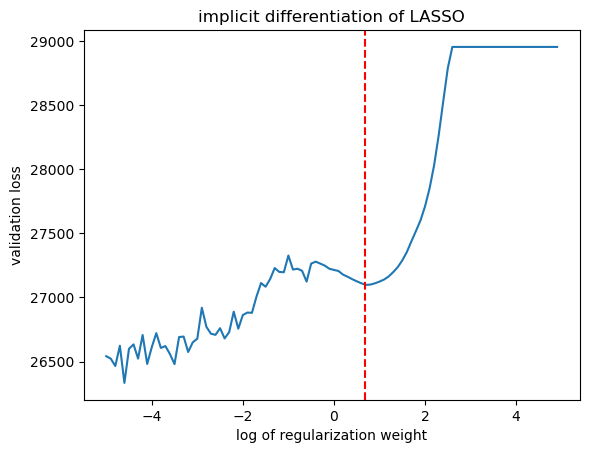

In [84]:
thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
plt.plot(thetas, loss)
plt.axvline(x=0.681, color='red', linestyle='--')
plt.xlabel('log of regularization weight')            # Label for x-axis
plt.ylabel('validation loss')            # Label for y-axis
plt.title('implicit differentiation of LASSO')  # Title of the plot

## Plot Hyperparameter Gradient

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.90000004
1.0
1.1
1.2
1.3000001
1.4
1.5
1.6
1.7
1.8000001
1.9


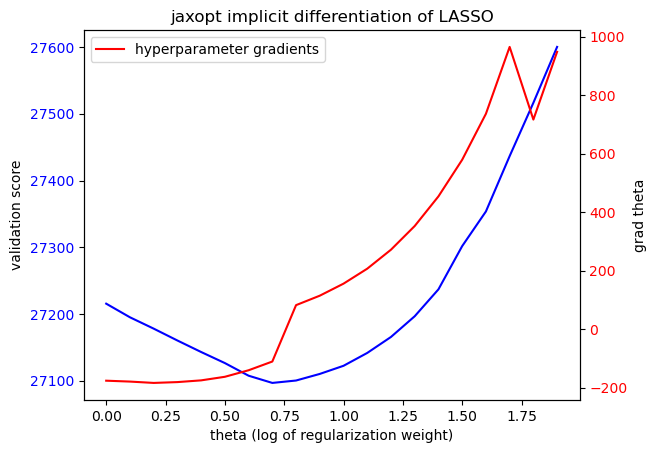

In [85]:
grad_theta = jax.grad(outer_objective, has_aux=True)

results = []
for theta in jnp.arange(0, 2, 0.1):
    loss, _ = outer_objective(theta, jnp.zeros(X.shape[1]), data)
    reg_grad, _ = grad_theta(theta, jnp.zeros(X.shape[1]), data)
    results.append([theta, loss, float(reg_grad)])
    print(theta)

thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
grads = np.array(results)[:, 2]

fig, ax1 = plt.subplots()
ax1.plot(thetas, loss, color='blue', label='validation scores')
ax1.set_xlabel('theta (log of regularization weight)')
ax1.set_ylabel('validation score')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(thetas, grads, color='red', label='hyperparameter gradients')
ax2.set_xlabel('theta (log of regularization weight)')
ax2.set_ylabel('grad theta')
ax2.tick_params(axis='y', labelcolor='red')

#plt.plot(thetas, loss, label='validation loss for theta')
           # Label for y-axis
plt.title('jaxopt implicit differentiation of LASSO')  # Title of the plot
plt.legend()